In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

#Please read comments for explanations

In [269]:
bank_df = pd.read_csv('bank.csv')

In [270]:
#Check Null
pd.isnull(bank_df).count()

RowNumber          10000
CustomerId         10000
Surname            10000
CreditScore        10000
Geography          10000
Gender             10000
Age                10000
Tenure             10000
Balance            10000
NumOfProducts      10000
HasCrCard          10000
IsActiveMember     10000
EstimatedSalary    10000
Exited             10000
dtype: int64

In [271]:
#Drop unnecessary columns that are unique to itself as labels
bank_df = bank_df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [272]:
#OneHot and Label Encode Cat Variables
bank_df_rev = pd.concat([bank_df, pd.get_dummies(bank_df['Geography'], drop_first=True)], axis=1).drop('Geography',axis=1).apply(LabelEncoder().fit_transform)

In [273]:
#Check Skewness and other statistical details on Continuous Variable
bank_df_stat = pd.concat([bank_df_rev.describe().T,bank_df_rev.skew()],axis=1).rename(columns = {0:'Skewness'})
bank_df_stat['Range']=bank_df_stat['max']-bank_df_stat['min']
bank_df_stat
#Age cannot be 0

,count,mean,std,min,25%,50%,75%,max,Skewness,Range
CreditScore,10000.0,259.5846,96.496107,0.0,193.00,261.0,327.00,459.0,-0.059871,459.0
Gender,10000.0,0.5457,0.497932,0.0,0.00,1.0,1.00,1.0,-0.183596,1.0
Age,10000.0,20.9206,10.482065,0.0,14.00,19.0,26.00,69.0,1.005451,69.0
Tenure,10000.0,5.0128,2.892174,0.0,3.00,5.0,7.00,10.0,0.010991,10.0
Balance,10000.0,2036.7881,2125.232536,0.0,0.00,1383.5,3882.25,6381.0,0.565124,6381.0
NumOfProducts,10000.0,0.5302,0.581654,0.0,0.00,0.0,1.00,3.0,0.745568,3.0
HasCrCard,10000.0,0.7055,0.455840,0.0,0.00,1.0,1.00,1.0,-0.901812,1.0
IsActiveMember,10000.0,0.5151,0.499797,0.0,0.00,1.0,1.00,1.0,-0.060437,1.0
EstimatedSalary,10000.0,4998.6212,2886.711202,0.0,2498.75,4998.5,7498.25,9998.0,0.000168,9998.0
Exited,10000.0,0.2037,0.402769,0.0,0.00,0.0,0.00,1.0,1.471611,1.0


In [274]:
#Drop rows with Age=0. 
print(bank_df_rev[bank_df_rev['Age']==0].Age.count()) #Shows 22 rows of age=0. Not a lot of data for deletion
bank_df_rev = bank_df_rev[bank_df_rev['Age']!=0]
print(bank_df_rev.shape)

22
(9978, 12)


In [275]:
#Check final dataset and make sure there are no Categorical values
print(bank_df_rev.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9978 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   CreditScore      9978 non-null   int64
 1   Gender           9978 non-null   int32
 2   Age              9978 non-null   int64
 3   Tenure           9978 non-null   int64
 4   Balance          9978 non-null   int64
 5   NumOfProducts    9978 non-null   int64
 6   HasCrCard        9978 non-null   int64
 7   IsActiveMember   9978 non-null   int64
 8   EstimatedSalary  9978 non-null   int64
 9   Exited           9978 non-null   int64
 10  Germany          9978 non-null   int64
 11  Spain            9978 non-null   int64
dtypes: int32(1), int64(11)
memory usage: 974.4 KB
None


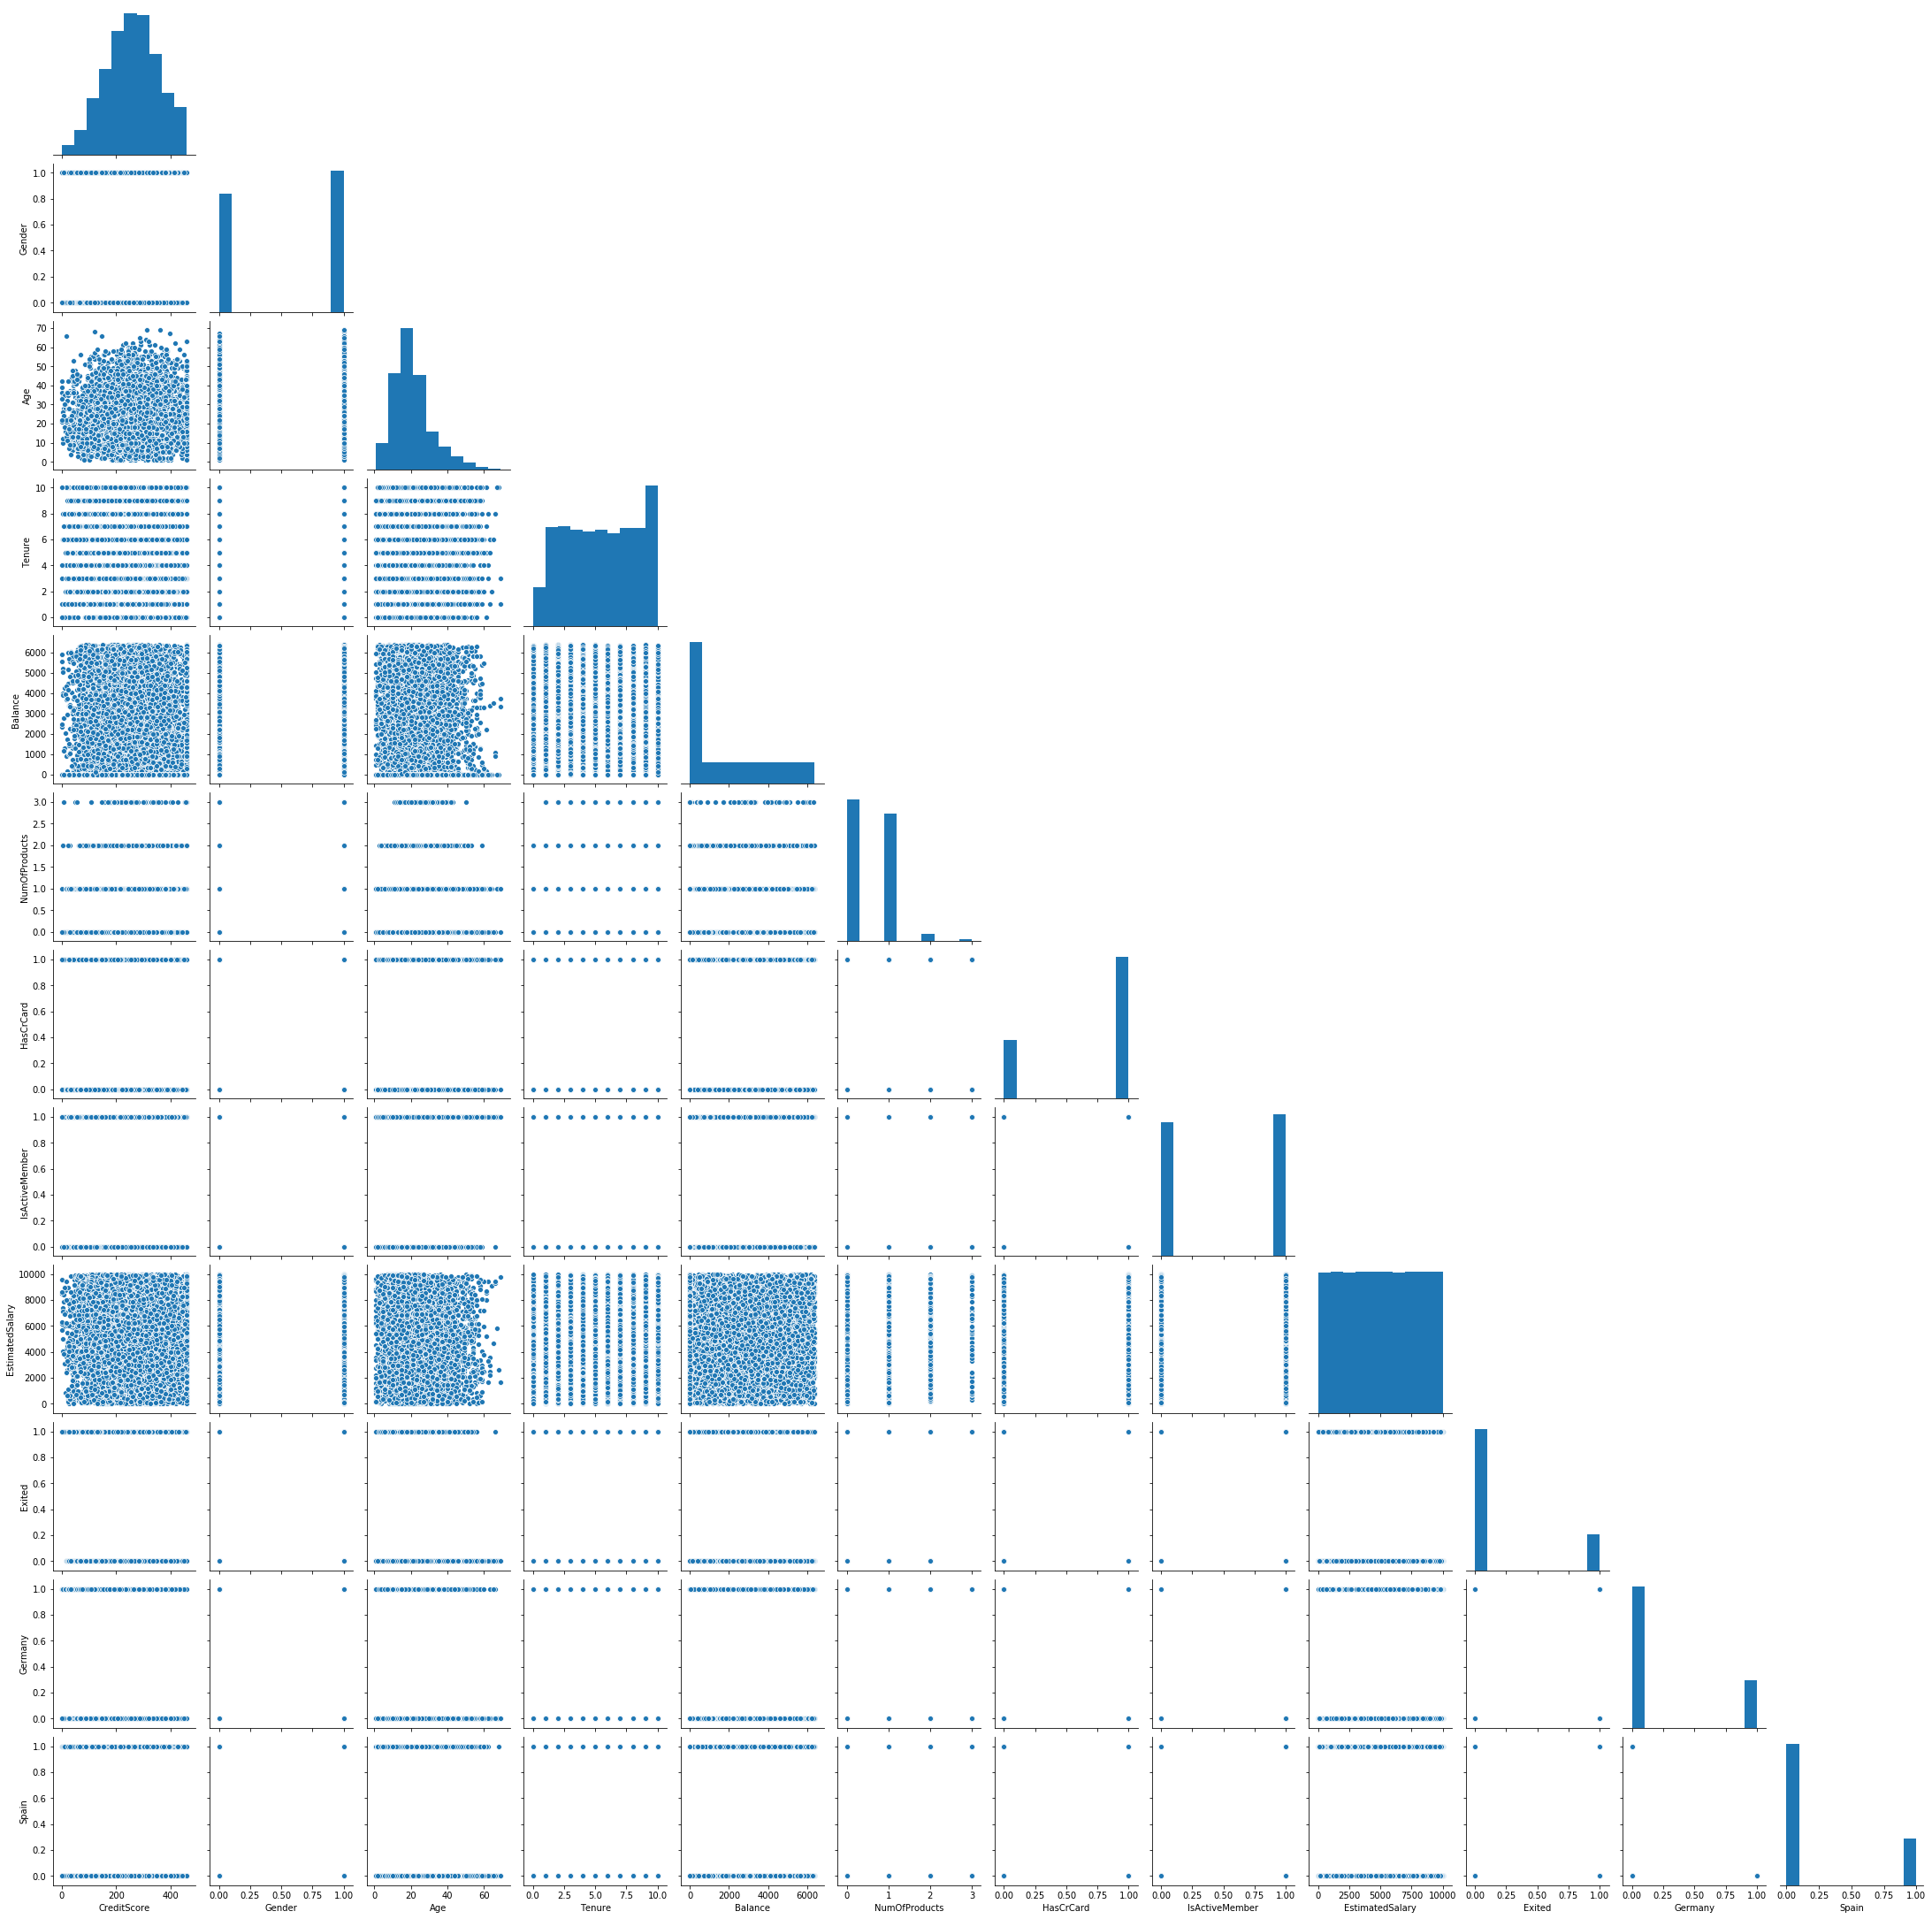

In [276]:
import seaborn as sns
sns.pairplot(bank_df_rev, corner=True)
#Age is skewed to left at younger age
#Exited Target value is not clustered to certain values of each feature. 
#Target value is well spread out throughout all values of each feature.
#All other feature to feature analysis shows well distributed out with very low correlation to each other.

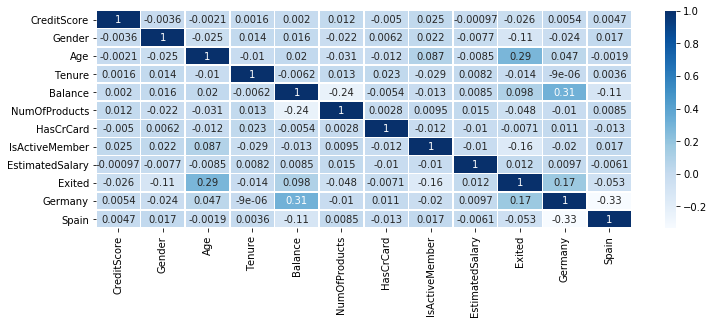

In [277]:
#Check pearson correlation values
corr = bank_df_rev.corr() 
fig, ax = plt.subplots(figsize=(12,4)) 
ax = sns.heatmap(corr, linewidths=0.5,annot=True, cmap='Blues')
#No strong correlation found.
#Diagnals are one because they are correlation to itself.
#All features with 0,1 values will not show correlation.
#None of them are linearly correlated [nor sine, cosine, circle, and etc.]

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Germany',
       'Spain'],
      dtype='object')


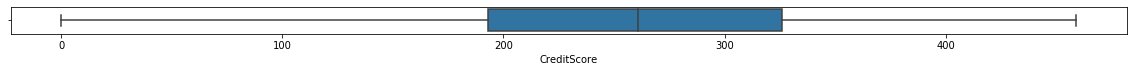

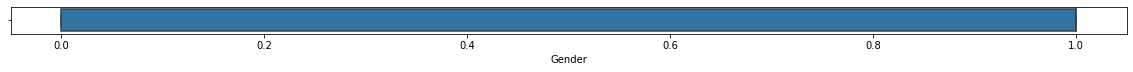

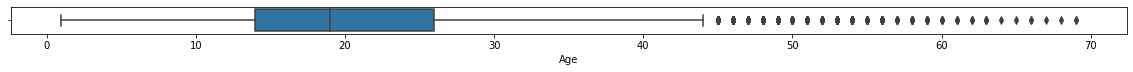

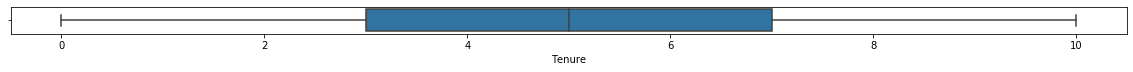

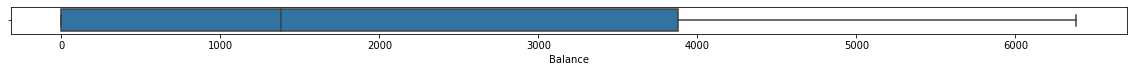

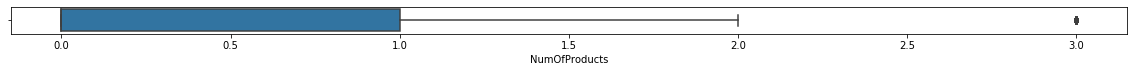

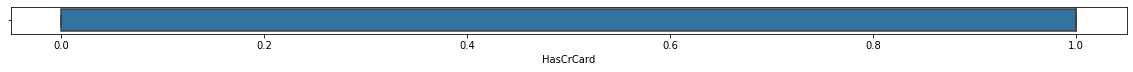

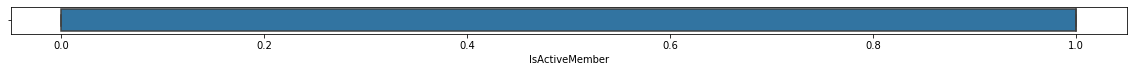

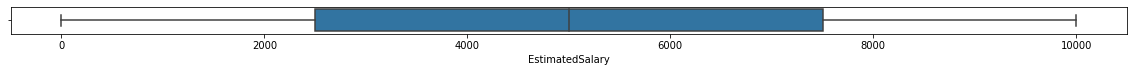

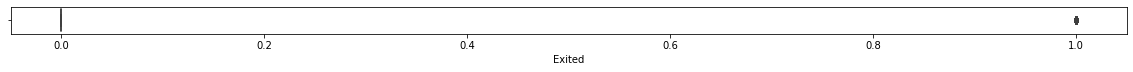

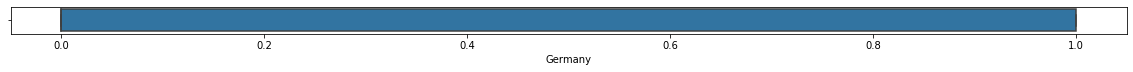

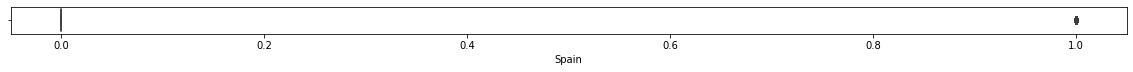

In [278]:
#Check for outliers and see if outliers are reasonable to keep
print(bank_df_rev.columns)
for c in bank_df_rev.columns:
    fig, axs = plt.subplots(figsize= (20,0.5))
    cont_plot = sns.boxplot(x=bank_df_rev[c])
    plt.show()
#Credit Score is well distributed out. 
#Age shows outliers at higher age. However, we are keeping the values as those can be true in reality
#Tenur is well distributed out.
#NumOfProduct shows outlier at 3. Also, we are keeping this as the value can be true in reality
#EstimateSalary is well distributed out.

#No other outlier remove is needed.

In [279]:
from sklearn.model_selection import train_test_split
# Specify the data 
X=bank_df_rev.drop('Exited',axis=1)
# Specify the target labels
y= bank_df_rev.Exited

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

#Normalize/Standardize split set
sc = StandardScaler()
X_train = sc.fit_transform(X_train) 
# X_val = sc.fit_transform(X_val) 
X_test = sc.transform(X_test)

#put target values to numpy array
y_train =  np.array(y_train) 
y_test =  np.array(y_test)

In [280]:
# Using Tensorflow Keras instead of the original Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
#Model Creation
model = Sequential()
# Adding the first hidden layer
model.add(Dense(11,activation='tanh', kernel_initializer='normal'))
# Adding the second hidden layer
model.add(Dense(10,activation='tanh'))
# Adding the output hidden layer
model.add(Dense(1,activation='sigmoid'))

# Compiling The Model
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size = 10, epochs = 10, validation_split = 0.2, verbose=False)
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

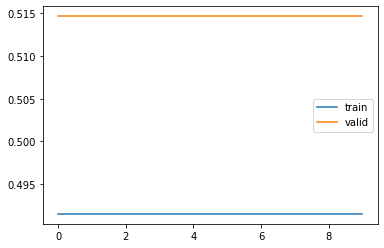

In [281]:
import matplotlib.pyplot as plt

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)
#plot shows model is totally invalid

In [282]:
from sklearn import metrics
#Predict using Threshold of 0.5
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.50)



# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)
print('\n\nConfusionMatrix:\n',cm)

#Accuracy is very low and Loss is 0 because model is not valid.

Accuracy: 0.506
Loss: 0.000


ConfusionMatrix:
 [[1207 1196]
 [ 284  307]]


- the model above was not good at all so need to use different approach to improve the model. (Shown below)

- Lower EPOCH will be used since the elbow is around at 5 (shown below uses epoch of 10). Using ephoc = 5 would improve computation speed.

- increasing or decreasing batch size from 10 to 5 or 15 does not improve model. For optimimal accuracy, batch size of 10 will be used. (shown below uses batch size of 10)

- Keeping relu because gradient computation is very simple (either 0 or 1 depending on the sign of x). Also, the computational step of a ReLU is easy that any negative elements are set to 0.0 and no exponentials, no multiplication or division operations. Therefore, this function was used in the beginning of the training to first hidden node with improving non-linearity.

- Because this is classification between two classes, the advantage of tanh is negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in the tanh graph. The function is differentiable. However, it is not recommended to use at the output activation function as this is binary classification problem. Using Tanh will not improve the model. (Model shown below)

- Lastly, sigmoid function is kept at the end so it can end up with either only 0 and 1

In [283]:
# Using Tensorflow Keras instead of the original Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
#Model Creation
model = Sequential()
# Adding the first hidden layer
model.add(Dense(11,activation='relu', kernel_initializer='normal'))
# Adding the second hidden layer
model.add(Dense(10,activation='tanh'))
# Adding the output hidden layer
model.add(Dense(1,activation='sigmoid'))



In [284]:
# Compiling The Model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size = 10, epochs = 10, validation_split = 0.2, verbose=False)
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

- I am using "adam" in replacement of stochastic gradient descent(sgd) because it provides an optimized algorithm that can handle sparse gradients on noisy problems. This will improve the efficiency on finding the most local/global minima. 

- Chose binary_crossentropy for computing the cross-entropy loss between true labels and predicted labels. Because Categorical cross entropy computes the crossentropy loss between the just labels and just predictions, it wouldn't be able to label properly.

In [265]:
from sklearn import metrics
#Predict using Threshold of 0.5
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.50)



# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)
print('\n\nConfusionMatrix:\n',cm)

Accuracy: 0.863
Loss: 0.346


ConfusionMatrix:
 [[2329   74]
 [ 336  255]]


Model improved drastically

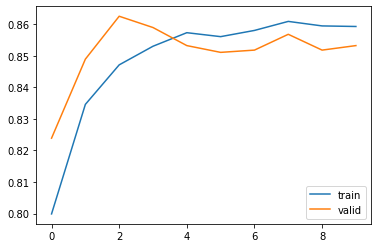

In [266]:
import matplotlib.pyplot as plt

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)
#shows after epoch=3, accuracy flattens. 

In [267]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

#Precision/Recall/f1-score for classifying '0' is higher than classifying '1'. 
#accuracy shows 86%

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2403
           1       0.78      0.43      0.55       591

    accuracy                           0.86      2994
   macro avg       0.82      0.70      0.74      2994
weighted avg       0.85      0.86      0.85      2994

